<a href="https://colab.research.google.com/github/vipul43/image_description/blob/main/image_description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# installs
!pip install tensorflow

In [37]:
# imports
import scipy.io
import cv2
from google.colab.patches import cv2_imshow
from skimage import io
import numpy as np
import pandas as pd
from PIL import Image 
import matplotlib.pylab as plt
import pickle
from skimage import transform
from sklearn.model_selection import train_test_split
import tensorflow as tf
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, LancasterStemmer
import spacy
import nltk
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import re
from tensorflow.keras.utils import to_categorical

In [5]:
nltk.download('punkt') #tokenizer
nltk.download('wordnet') #lemmatization
lemmatizer = WordNetLemmatizer() #lemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [6]:
# data loading
!gdown --id 1mrjvJq6XNM8QAgajSgrVGpsj8Vrm3BEm #PASCAL50S

mat = scipy.io.loadmat('/content/pascal50S.mat')

Downloading...
From: https://drive.google.com/uc?id=1mrjvJq6XNM8QAgajSgrVGpsj8Vrm3BEm
To: /content/pascal50S.mat
100% 1.12M/1.12M [00:00<00:00, 72.1MB/s]


In [7]:
#creating tokenizer on the dataset
stringX2 = []
stop_words=['the', 'a', 'and', 'is', 'be', 'will']
for sample in mat["train_sent_final"][0]:
  for k in sample[1]:
    for sent in k[:10]:
      new_sent = "<start> "
      sentence = re.sub(r'[^\w\s]','',sent[0])
      sentence = sentence.lower()
      sentence = ' '.join([word for word in sentence.split() if word not in stop_words])  #removing stop words
      for word in sentence.split():
        pre_word = lemmatizer.lemmatize(word)
        new_sent+=pre_word+" "
      new_sent+="<end>"
      stringX2.append(new_sent)

tk = Tokenizer(filters='')
tk.fit_on_texts(stringX2)
print(len(tk.word_index))

3485


In [8]:
#preprocessing data
max_len = 0
data = []
stop_words=['the', 'a', 'and', 'is', 'be', 'will']
for sample in mat["train_sent_final"][0]:
  link = sample[0][0]
  plural = []
  for sent in sample[1][0][:10]:
    new_sent = "<start> "
    sentence = re.sub(r'[^\w\s]','',sent[0])
    sentence = sentence.lower()
    sentence = ' '.join([word for word in sentence.split() if word not in stop_words])  #removing stop words
    length = 0
    for word in sentence.split():
      length+=1
      pre_word = lemmatizer.lemmatize(word)
      new_sent+=pre_word+" "
    max_len = max(max_len, length)
    new_sent+="<end>"
    plural.append(new_sent)
  data.append([link, plural])
print(len(data))
print(max_len)

1000
22


##Model

In [40]:
# model making(Image to Vector)
# input layer
input1 = tf.keras.Input(shape=(224, 224, 3), name='input1')

# Transfer Learning with VGG16 model with weights as imagenet
vgg16 = tf.keras.applications.VGG16(include_top=False, weights="imagenet", classes=20)
vgg16.trainable = False
x = vgg16(input1)

# Dense Layers
x = tf.keras.layers.Flatten(name='flatten')(x)
x = tf.keras.layers.BatchNormalization(name='norm1')(x)
x = tf.keras.layers.Dense(192, activation='relu', name='dense1')(x)
x = tf.keras.layers.BatchNormalization(name='norm2')(x)
x = tf.keras.layers.Dense(84, activation='relu', name='dense2')(x)
x = tf.keras.layers.BatchNormalization(name='norm3')(x)
x = tf.keras.layers.Dense(64, activation='relu', name='dense3')(x)
x = tf.keras.layers.BatchNormalization(name='norm4')(x)

#Output layer
output = tf.keras.layers.Dense(500, activation="linear", name='output')(x)
model1 = tf.keras.models.Model(inputs=input1, outputs=output, name='model1')
model1.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
norm1 (BatchNormalization)   (None, 25088)             100352    
_________________________________________________________________
dense1 (Dense)               (None, 192)               4817088   
_________________________________________________________________
norm2 (BatchNormalization)   (None, 192)               768       
_________________________________________________________________
dense2 (Dense)               (None, 84)                16212

In [10]:
# # functions to enable the task

def get_coefs(word, *arr): 
  return word, np.asarray(arr, dtype='float32')

def get_embeddings_matrix(embed_path, embed_dim, tokenizer, vocab_len):
  embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(embed_path, errors='ignore'))
  embedding_matrix = np.zeros((vocab_len + 1, embed_dim))
  for word, index in tokenizer.word_index.items():
    if index > vocab_len:
      break
    else:
      try:
          embedding_matrix[index] = embeddings_index[word]
      except:
          continue
  return embedding_matrix

In [12]:
!gdown --id 1C4EF6dN5sE28XFm7CefcWBgzRwfF90Pz
!unzip /content/glove.42B.300d.zip &> /dev/null
!rm -rf /content/glove.42B.300d.zip &> /dev/null

Downloading...
From: https://drive.google.com/uc?id=1C4EF6dN5sE28XFm7CefcWBgzRwfF90Pz
To: /content/glove.42B.300d.zip
1.88GB [00:19, 94.3MB/s]


In [13]:
embed_path = '/content/glove.42B.300d.txt'
EMBED_DIM = 300
EMBEDDING_MATRIX = get_embeddings_matrix(embed_path, EMBED_DIM, tk, len(tk.word_index))
print("Embeddings Matrix shape: ", EMBEDDING_MATRIX.shape)

Embeddings Matrix shape:  (3486, 300)


In [39]:
input2 = tf.keras.Input(shape=(max_len,))
# x = tf.keras.layers.Embedding((len(tk.word_counts)+1),100)(input2)
x = tf.keras.layers.Embedding(len(tk.word_index)+1, EMBED_DIM, weights=[EMBEDDING_MATRIX], trainable=False)(input2)
x = tf.keras.layers.LSTM(192, return_sequences=True, dropout=0.3)(x)
x = tf.keras.layers.MaxPool1D()(x)
x = tf.keras.layers.LSTM(128, dropout=0.2)(x)
x = tf.keras.layers.Dense(84, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Dense(100, activation='linear')(x)

model2 = tf.keras.models.Model(inputs=input2, outputs=output, name='model2')
model2.summary()

Model: "model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 22)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 22, 300)           1045800   
_________________________________________________________________
lstm_2 (LSTM)                (None, 22, 192)           378624    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 192)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               164352    
_________________________________________________________________
dense_6 (Dense)              (None, 84)                10836     
_________________________________________________________________
dropout_1 (Dropout)          (None, 84)                0    

**Concatenating the Image Model(Model1) and Text Model(Model2)**

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input1[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 25088)        0           vgg16[0][0]                      
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 22)]         0                                            
____________________________________________________________________________________________

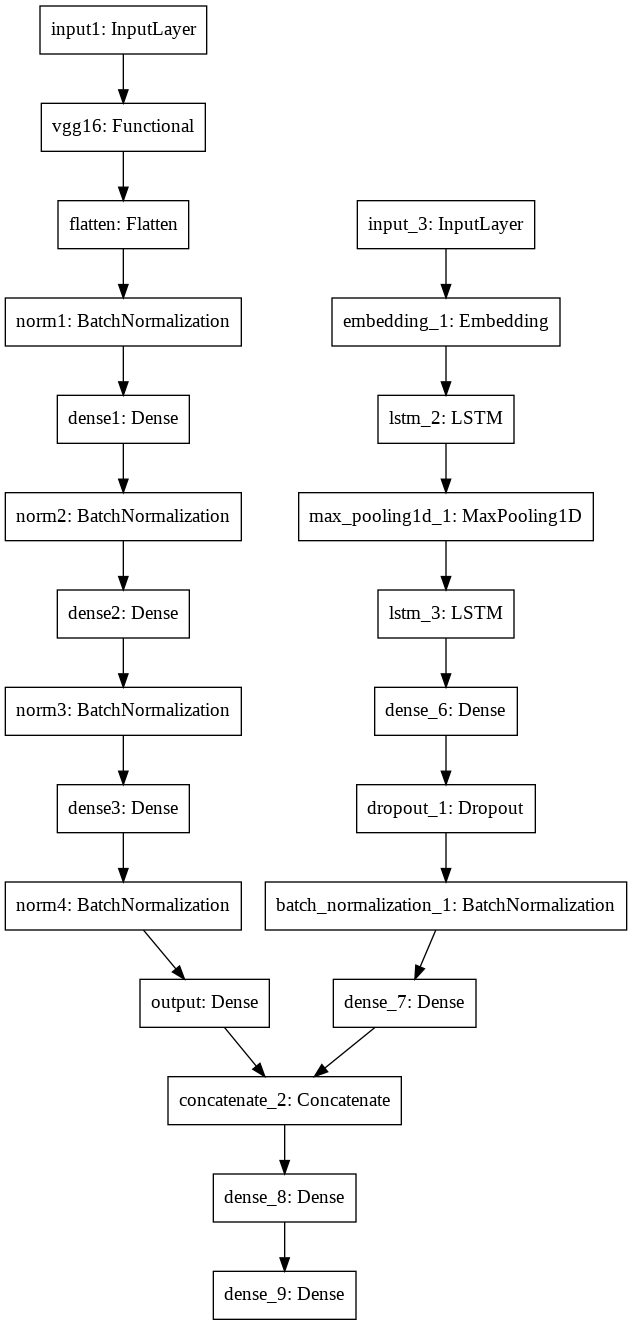

In [41]:
concate = tf.keras.layers.Concatenate(axis=-1)([model1.output, model2.output])
final_dense = tf.keras.layers.Dense(256, activation='relu')(concate)
Output = tf.keras.layers.Dense(len(tk.word_counts)+1, activation='softmax')(final_dense)
finalModel  = tf.keras.models.Model(inputs=[input1,input2],outputs=Output)

finalModel.summary()
tf.keras.utils.plot_model(finalModel,to_file="finalModel.png")

In [42]:
finalModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00001), loss='categorical_crossentropy', metrics=['acc'])

In [45]:
batch_size = 1
steps = len(data)//batch_size
generator = data_generator(data,tk, (224, 224, 3), batch_size, max_len)
finalModel.fit(generator, epochs=5, steps_per_epoch=steps, shuffle=True)

Epoch 1/5
1000/1000 [==============================] - 1246s 1s/step - loss: 7.4300 - acc: 0.1202
Epoch 2/5
1000/1000 [==============================] - 572s 572ms/step - loss: 5.7533 - acc: 0.1510
Epoch 3/5
1000/1000 [==============================] - 570s 570ms/step - loss: 5.4359 - acc: 0.1534
Epoch 4/5
1000/1000 [==============================] - 569s 569ms/step - loss: 5.3392 - acc: 0.1572
Epoch 5/5
1000/1000 [==============================] - 575s 575ms/step - loss: 5.2926 - acc: 0.1601


original label  ['<start> this picture of small black white dog <end>', '<start> closeup of black white pug with maroon collar <end>', '<start> dog standing in front of striped wall paper <end>', '<start> dog sitting down look on <end>', '<start> brown pug dog standing in room decorated with wallpaper <end>', '<start> dog staring down into camera <end>', '<start> dog looking at camera <end>', '<start> black white dog posing for camera <end>', '<start> pug mean mugging camera <end>', '<start> close up shot of small dog <end>']
predicted label  riding riding riding riding riding riding riding riding riding riding riding riding riding riding riding riding riding riding riding riding riding


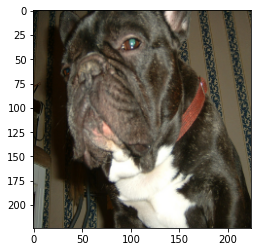

In [46]:
idx = np.random.randint(len(data))
photo = io.imread(data[idx][0])
photo = transform.resize(image=photo, output_shape=(224, 224, 3))
label = data[idx][1]
pred = predict(photo, finalModel, max_len)
plt.imshow(photo)
print("original label ", label)
print("predicted label ", pred)

In [47]:
finalModel.fit(generator, epochs=5, steps_per_epoch=steps, shuffle=True)

Epoch 1/5
1000/1000 [==============================] - 568s 568ms/step - loss: 5.2554 - acc: 0.1618
Epoch 2/5
1000/1000 [==============================] - 571s 571ms/step - loss: 5.2216 - acc: 0.1645
Epoch 3/5
1000/1000 [==============================] - 568s 568ms/step - loss: 5.1891 - acc: 0.1656
Epoch 4/5
1000/1000 [==============================] - 568s 568ms/step - loss: 5.1604 - acc: 0.1664
Epoch 5/5
1000/1000 [==============================] - 567s 567ms/step - loss: 5.1336 - acc: 0.1680


In [48]:
finalModel.fit(generator, epochs=5, steps_per_epoch=steps, shuffle=True)

Epoch 1/5
1000/1000 [==============================] - 569s 569ms/step - loss: 5.1069 - acc: 0.1697
Epoch 2/5
1000/1000 [==============================] - 569s 569ms/step - loss: 5.0832 - acc: 0.1704
Epoch 3/5
1000/1000 [==============================] - 570s 570ms/step - loss: 5.0599 - acc: 0.1717
Epoch 4/5
1000/1000 [==============================] - 575s 575ms/step - loss: 5.0340 - acc: 0.1719
Epoch 5/5
1000/1000 [==============================] - 576s 576ms/step - loss: 5.0127 - acc: 0.1726


In [49]:
finalModel.fit(generator, epochs=5, steps_per_epoch=steps, shuffle=True)

Epoch 1/5
1000/1000 [==============================] - 572s 572ms/step - loss: 4.9914 - acc: 0.1744
Epoch 2/5
1000/1000 [==============================] - 571s 571ms/step - loss: 4.9719 - acc: 0.1763
Epoch 3/5
1000/1000 [==============================] - 572s 572ms/step - loss: 4.9551 - acc: 0.1756
Epoch 4/5
1000/1000 [==============================] - 580s 580ms/step - loss: 4.9372 - acc: 0.1781
Epoch 5/5
1000/1000 [==============================] - 595s 595ms/step - loss: 4.9200 - acc: 0.1800


## Model2

In [44]:
#data generator
def data_generator(data, tk, new_shape, batch_size, max_len):
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for point in data:
      n+=1
      photo = io.imread(point[0])
      photo = transform.resize(image=photo, output_shape=new_shape, preserve_range=True)
      for sent in point[1]:
        seq = [tk.word_index[word] for word in sent.split(' ') if word in tk.word_index.keys()]
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_len, padding='post')[0]
          out_seq = to_categorical([out_seq], num_classes=len(tk.word_index)+1)[0]
          X1.append(photo)
          X2.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        yield ([np.asarray(X1), np.asarray(X2)], np.asarray(y))
        X1, X2, y = list(), list(), list()
        n=0

# predict function
index_word = dict(map(reversed, tk.word_index.items()))
def predict(image, finalModel, max_len):
  partial_caption = "<start>"
  for i in range(max_len):
    seq = [tk.word_index[word] for word in partial_caption.split() if word in tk.word_index.keys()]
    seq = pad_sequences([seq], maxlen=max_len, padding='post')
    yhat = finalModel.predict([np.expand_dims(image, 0),[seq]], verbose=0)
    yhat = np.argmax(yhat)
    word = index_word[yhat]
    partial_caption += (' ' + word)
    if word == "<end>":
        break
  final_caption = partial_caption.split()[1:-1]
  final_caption = ' '.join(final_caption)
  return final_caption

In [ ]:
# define the captioning model
from keras.layers.merge import add

def define_model(vocab_size, max_length, lr=0.001):
  # feature extractor model
  inputs1 = tf.keras.Input(shape=(224, 224, 3))
  norm_inputs1 = tf.keras.layers.BatchNormalization()(inputs1)
  conv1 = tf.keras.layers.Conv2D(kernel_size=(3, 3),filters=10, padding="same")(norm_inputs1)
  pool1 = tf.keras.layers.MaxPool2D(pool_size = (3,3), padding="same")(conv1)
  conv2 = tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=16, padding="same")(pool1)
  pool2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), padding="same")(conv2)
  flat = tf.keras.layers.Flatten(name='flatten')(pool2)
  fe1 = tf.keras.layers.Dropout(0.5)(flat)
  fe2 = tf.keras.layers.Dense(256, activation='relu')(fe1)
  # sequence model
  inputs2 = tf.keras.Input(shape=(max_length,))
  se1 = tf.keras.layers.Embedding(vocab_size, 256, mask_zero=True)(inputs2)
  se2 = tf.keras.layers.Dropout(0.5)(se1)
  se3 = tf.keras.layers.LSTM(256)(se2)
  # decoder model
  decoder1 = tf.keras.layers.Concatenate(axis=-1)([fe2, se3])
  decoder2 = tf.keras.layers.Dense(256, activation='relu')(decoder1)
  outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder2)
  # tie it together [image, seq] [word]
  model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
  # summarize model
  print(model.summary())
  tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)
  return model

In [ ]:
# def find_max_len(data):
#   max_len = 0
#   # i = 0
#   for sample in data:
#     # i += 1
#     # print(data[0][1])
#     # if(i > 20):
#     #   break
#     max_len = max(max_len, len(sample[1].split()))
#   return max_len
# find_max_len(data)

In [ ]:
max_length = max_len
vocab_size = len(tk.word_counts) + 1
learning_rate = 0.003
model_g1 = define_model(vocab_size, max_length, learning_rate)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 10) 280         batch_normalization[0][0]        
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 75, 75, 10)   0           conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
batch_size = 16
steps = len(data)//batch_size
generator = data_generator(data,tk, (224, 224, 3), batch_size, max_len)
model_g1.fit(generator, epochs=10, steps_per_epoch=steps, shuffle=True)

Epoch 1/10
62/62 [==============================] - 616s 9s/step - loss: 6.2851
Epoch 2/10
62/62 [==============================] - 578s 9s/step - loss: 5.2039
Epoch 3/10
62/62 [==============================] - 588s 9s/step - loss: 4.7714
Epoch 4/10
62/62 [==============================] - 566s 9s/step - loss: 4.4989
Epoch 5/10
62/62 [==============================] - 575s 9s/step - loss: 4.2077
Epoch 6/10
62/62 [==============================] - 591s 10s/step - loss: 3.9553
Epoch 7/10
62/62 [==============================] - 592s 10s/step - loss: 3.7589
Epoch 8/10
15/62 [======>.......................] - ETA: 7:11 - loss: 3.6151

KeyboardInterrupt: ignored

In [ ]:
model_g1.fit(generator, epochs=5, steps_per_epoch=steps, shuffle=True)

original label  ['<start> rider are mounted above horse ready to ride <end>', '<start> there are three young lady wearing helmet riding horse <end>', '<start> rider sit on their horse outside <end>', '<start> three jockey on three different horse <end>', '<start> three people with dressed to ride their horse around <end>', '<start> three girl on their horse in training school <end>', '<start> group of people sitting on horse <end>', '<start> people are riding many color of horse <end>', '<start> rider on their horse prepare for show <end>', '<start> woman horse riding inside animal corral <end>']
predicted label  man riding horse


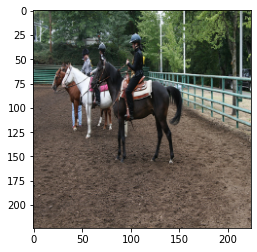

In [ ]:
idx = np.random.randint(len(data))
photo = io.imread(data[idx][0])
photo2 = transform.resize(image=photo, output_shape=(224, 224, 3))
photo = transform.resize(image=photo, output_shape=(224, 224, 3), preserve_range=True)
label = data[idx][1]
pred = predict(photo, model_g1, max_length)
plt.imshow(photo2)
print("original label ", label)
print("predicted label ", pred)

In [ ]:
# # partial_caption = "<start> the"
# # seq = [tk.word_index[word] for word in partial_caption.split() if word in tk.word_index.keys()]
# # seq = pad_sequences([seq], maxlen=100)
# # yhat = finalModel.predict([np.expand_dims(photo, 0),[seq]], verbose=0)
# # yhat = np.argmax(yhat)
# # word = index_word[yhat]
# # word

# tk.word_index['a']

194

In [ ]:
# idx = np.random.randint(len(data))
# photo = io.imread(data[idx][0])
# photo = transform.resize(image=photo, output_shape=(224, 224, 3))
# label = data[idx][1]
# pred = predict(photo, finalModel)
# plt.imshow(photo)
# print("original label ", label)
# print("predicted label ", pred)

NameError: ignored

In [ ]:
# plotting curves
'''
loss -> train, val
accuracy -> train, val
'''
plt.plot(list(history.history.values())[0])
plt.plot(list(history.history.values())[2])
plt.title('Loss Plot')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.show()

plt.plot(list(history.history.values())[1])
plt.plot(list(history.history.values())[3])
plt.title('Accuracy Plot')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()